In [12]:
import pandas as pd
import matplotlib.pylab as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
import joblib
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
from imblearn.over_sampling import SMOTE
from scipy.stats import randint

In [13]:
df = pd.read_csv('Preprocessed_Data.csv')

In [14]:
df.shape

(27273, 26)

In [15]:
df.head()

,Unnamed: 0,inningNumber,oversActual,pitchLine,pitchLength,isFour,isSix,isWicket,byes,legbyes,wides,noballs,run,totalRuns,totalWickets,shotType,time_of_day,Ground Name,Batsman_Name,Batsman_Role,Batsman_Batting_Style,Batsman_Playing_Role,Bowler_Name,Bowler_Role,Bowler_Bowling_Style,Bowler_Playing_Role
0,0,1,0.1,1,2,False,False,False,0,0,0,0,0,0,0,3,0,1,360,2,1,6,47,1,4,3
1,1,1,0.2,1,4,False,False,False,0,0,0,0,0,0,0,1,0,1,360,2,1,6,47,1,4,3
2,2,1,0.3,1,2,False,False,False,0,0,0,0,0,0,0,3,0,1,360,2,1,6,47,1,4,3
3,3,1,0.4,1,2,False,False,False,0,0,0,0,0,0,0,4,0,1,360,2,1,6,47,1,4,3
4,4,1,0.5,1,2,False,False,True,0,0,0,0,0,0,0,0,0,1,360,2,1,6,47,1,4,3


In [16]:
df.columns

Index(['Unnamed: 0', 'inningNumber', 'oversActual', 'pitchLine', 'pitchLength',
       'isFour', 'isSix', 'isWicket', 'byes', 'legbyes', 'wides', 'noballs',
       'run', 'totalRuns', 'totalWickets', 'shotType', 'time_of_day',
       'Ground Name', 'Batsman_Name', 'Batsman_Role', 'Batsman_Batting_Style',
       'Batsman_Playing_Role', 'Bowler_Name', 'Bowler_Role',
       'Bowler_Bowling_Style', 'Bowler_Playing_Role'],
      dtype='object')

Selected features based on correlation:
 ['oversActual', 'totalRuns', 'Ground Name', 'Batsman_Name', 'Batsman_Playing_Role']
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Parameters Found: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 71}

--- Shot Type (Train) ---
Accuracy: 0.5992758272985608
              precision    recall  f1-score   support

           0       0.70      0.54      0.61      2333
           1       0.67      0.57      0.61      1891
           2       0.36      0.79      0.49       142
           3       0.63      0.62      0.62      2177
           4       0.81      0.50      0.62      3821
           5       0.33      0.82      0.47        51
           6       0.47      0.64      0.55       671
           7       0.33      0.79      0.46       201
           8       0.75      0.54      0.63      3208
           9       0.00      0.00      0.00         2
          10       0.28      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


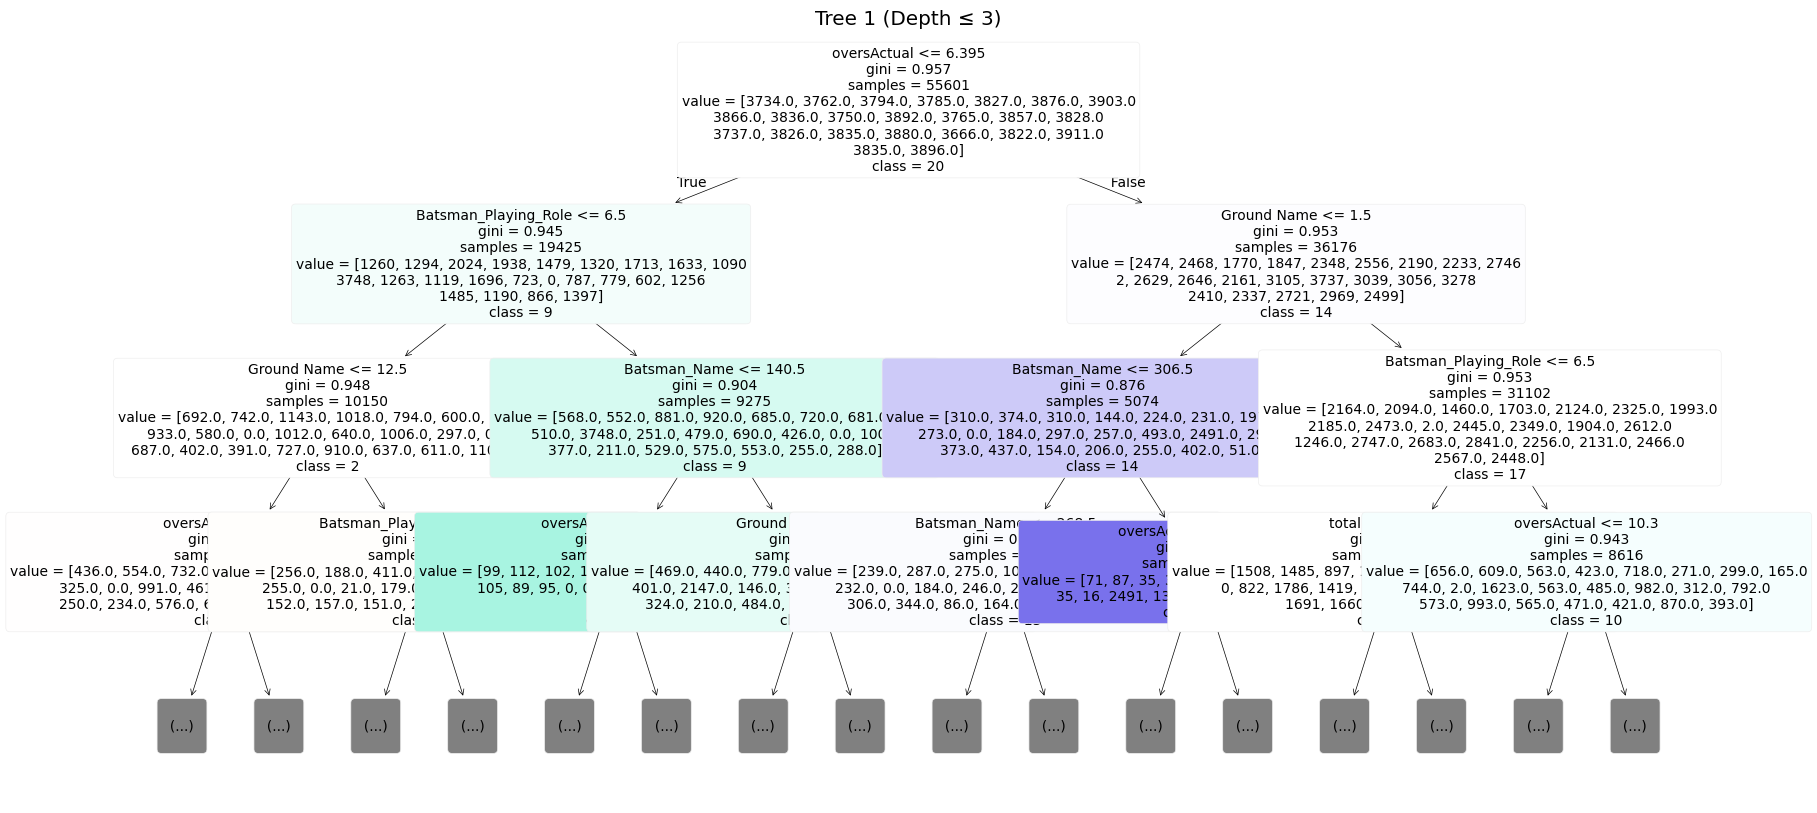

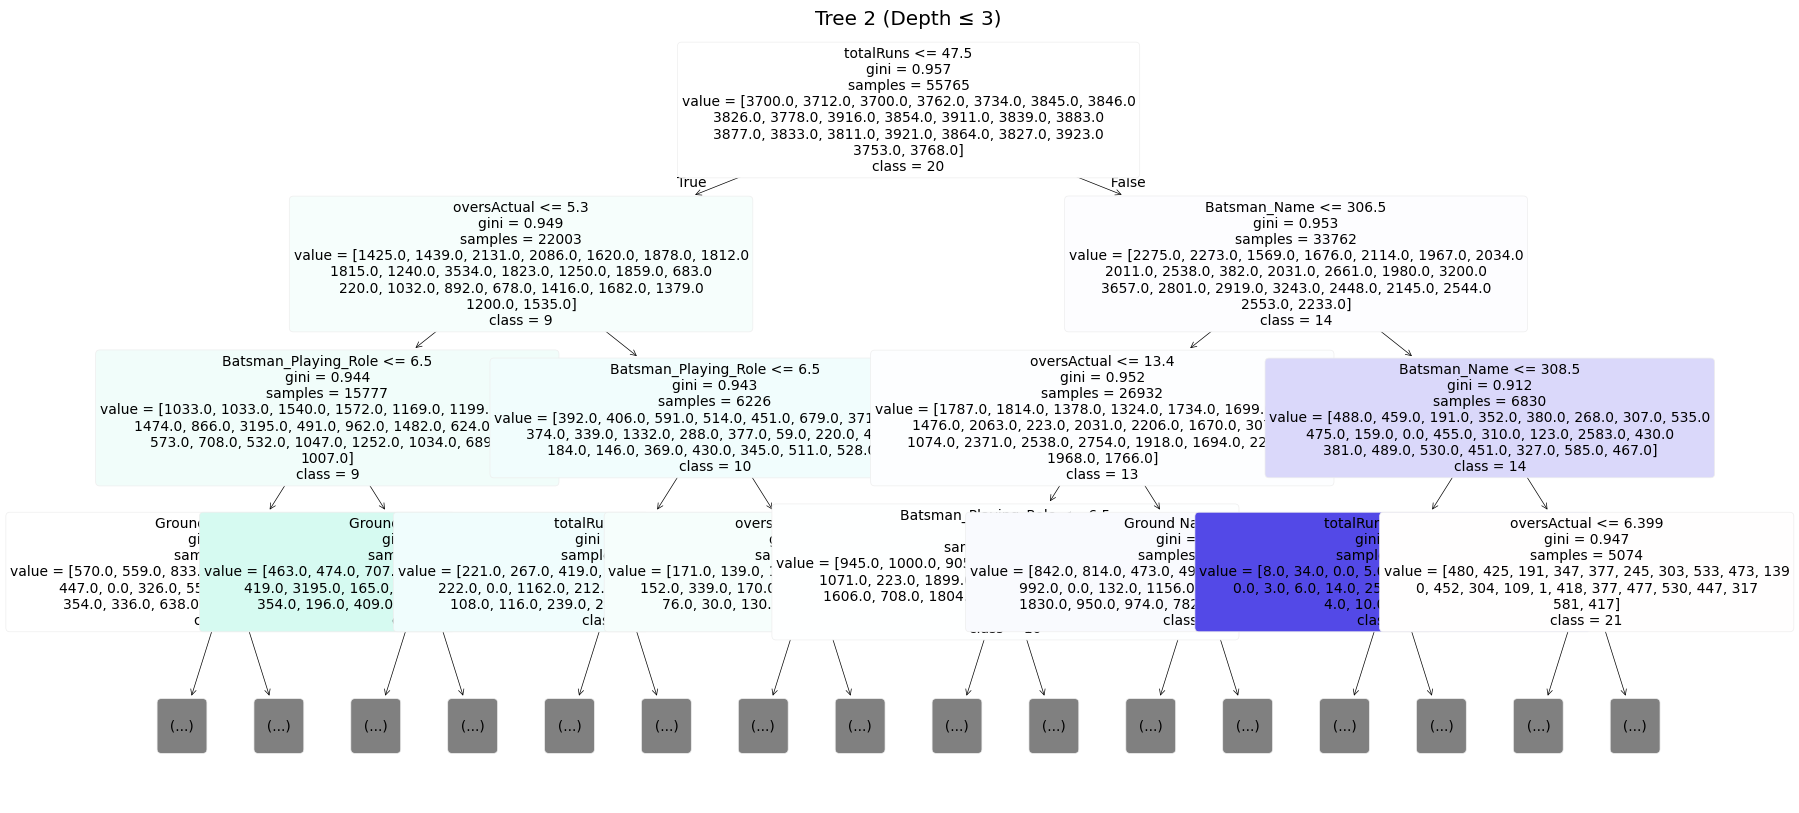

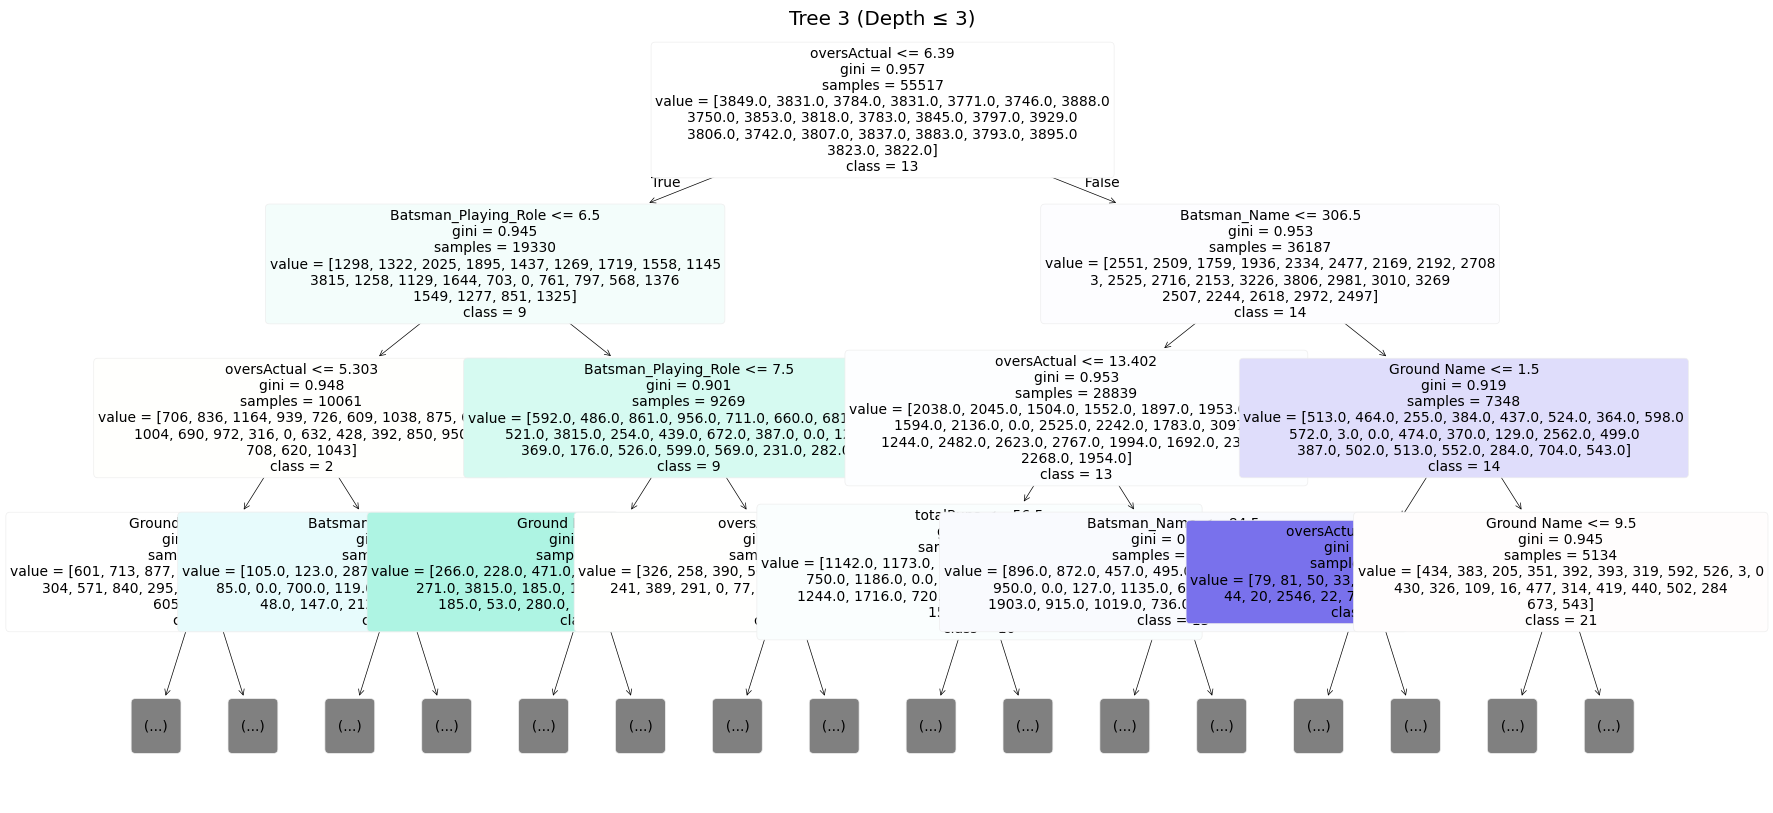

['shot_type_best_model.pkl']

In [21]:
df_copy = df.copy()

input_cols = ['inningNumber', 'oversActual', 'totalRuns', 'totalWickets',
              'time_of_day', 'Ground Name', 'Batsman_Name', 'Batsman_Role',
              'Batsman_Batting_Style', 'Batsman_Playing_Role']

from sklearn.feature_selection import mutual_info_classif
mi_scores = mutual_info_classif(df_copy[input_cols], df_copy['shotType'], discrete_features='auto')
selected_features = [f for f, score in zip(input_cols, mi_scores) if score > 0.01]

print("Selected features based on correlation:\n", selected_features)

X = df_copy[selected_features]
y = df_copy['shotType']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

min_samples = 2
class_counts = y_train.value_counts()
valid_classes = class_counts[class_counts >= min_samples].index
mask = y_train.isin(valid_classes)

X_train_filtered = X_train[mask]
y_train_filtered = y_train[mask]

sm = SMOTE(random_state=42, k_neighbors=1)
X_train_res, y_train_res = sm.fit_resample(X_train_filtered, y_train_filtered)

param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [3, 15],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt']
}

cv_strategy = StratifiedKFold(n_splits=5)

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=cv_strategy,
                                   scoring='roc_auc_ovr',
                                   n_jobs=-1,
                                   verbose=2,
                                   random_state=42)

random_search.fit(X_train_res, y_train_res)
best_model = random_search.best_estimator_

print("\nBest Parameters Found:", random_search.best_params_)

y_train_pred = best_model.predict(X_train)
print("\n--- Shot Type (Train) ---")
print("Accuracy:", accuracy_score(y_train, y_train_pred))
print(classification_report(y_train, y_train_pred))

y_test_pred = best_model.predict(X_test)
print("\n--- Shot Type (Test) ---")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))

for i in range(min(3, len(best_model.estimators_))):
    plt.figure(figsize=(20, 10))
    plot_tree(best_model.estimators_[i],
              max_depth=3,
              feature_names=X.columns,
              class_names=[str(cls) for cls in best_model.classes_],
              filled=True, rounded=True, fontsize=10)
    plt.title(f"Tree {i+1} (Depth ≤ 3)")
    plt.show()

joblib.dump(best_model, 'shot_type_best_model.pkl')

In [25]:
threshold = 2
df_copy = df.copy()
df_copy['target'] = ((df_copy['isWicket'] == 1) | (df_copy['run'] <= threshold)).astype(int)

input_cols = ['inningNumber', 'oversActual', 'totalRuns', 'totalWickets',
              'time_of_day', 'Ground Name', 'Batsman_Name', 'Batsman_Role',
              'Batsman_Batting_Style', 'Batsman_Playing_Role']
target_outputs = ['pitchLine', 'pitchLength', 'Bowler_Bowling_Style']

df_good = df_copy[df_copy['target'] == 1]




param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt']
}

for target_col in target_outputs:
    print(f"\n--- Tuning and Training for: {target_col} ---")
    mi_scores = mutual_info_classif(df_good[input_cols], df_good[target_col], discrete_features='auto')
    selected_features = [f for f, score in zip(input_cols, mi_scores) if score > 0.01]
    print("Selected features: ", selected_features)
    X = df_good[selected_features]
    y = df_good[target_col]

    X_temp, X_test, y_temp, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

    min_samples = 2
    class_counts = y_temp.value_counts()
    valid_classes = class_counts[class_counts >= min_samples].index
    mask = y_temp.isin(valid_classes)

    X_filtered = X_temp[mask]
    y_filtered = y_temp[mask]

    sm = SMOTE(random_state=42, k_neighbors=1)
    X_resampled, y_resampled = sm.fit_resample(X_filtered, y_filtered)

    cv_strategy = StratifiedKFold(n_splits=5)
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=10,
                                       cv=cv_strategy,
                                       scoring='roc_auc_ovr',
                                       n_jobs=-1,
                                       verbose=2,
                                       random_state=42)
    random_search.fit(X_resampled, y_resampled)
    best_model = random_search.best_estimator_

    print("Best Parameters:", random_search.best_params_)

    y_train_pred = best_model.predict(X_temp)
    print("\n--- Train Performance ---")
    print("Accuracy:", accuracy_score(y_temp, y_train_pred))
    print(classification_report(y_temp, y_train_pred))

    y_test_pred = best_model.predict(X_test)
    print("\n--- Test Performance ---")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

    for i in range(min(3, len(best_model.estimators_))):
        plt.figure(figsize=(20, 10))
        plot_tree(best_model.estimators_[i],
                  max_depth=3,
                  feature_names=X.columns,
                  class_names=[str(cls) for cls in best_model.classes_],
                  filled=True, rounded=True, fontsize=10)
        plt.title(f"{target_col} - Tree {i+1} (Depth ≤ 3)")
        plt.show()

    joblib.dump(best_model, f'{target_col}_safe_best_model.pkl')

Output hidden; open in https://colab.research.google.com to view.


=== Avoidance Model for pitchLine ===
Selected features:  ['totalWickets', 'Ground Name', 'Batsman_Name']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 91}

--- Train Performance ---
Accuracy: 0.6714929214929215
              precision    recall  f1-score   support

           0       0.42      0.63      0.50       253
           1       0.65      0.67      0.66      1020
           2       0.80      0.67      0.73      1578
           3       0.27      0.40      0.32        10
           4       0.51      0.70      0.59       247

    accuracy                           0.67      3108
   macro avg       0.53      0.62      0.56      3108
weighted avg       0.70      0.67      0.68      3108


--- Test Performance ---
Accuracy: 0.39974293059125965
              precision    recall  f1-score   support

           0       0.15      0.27      0.19     

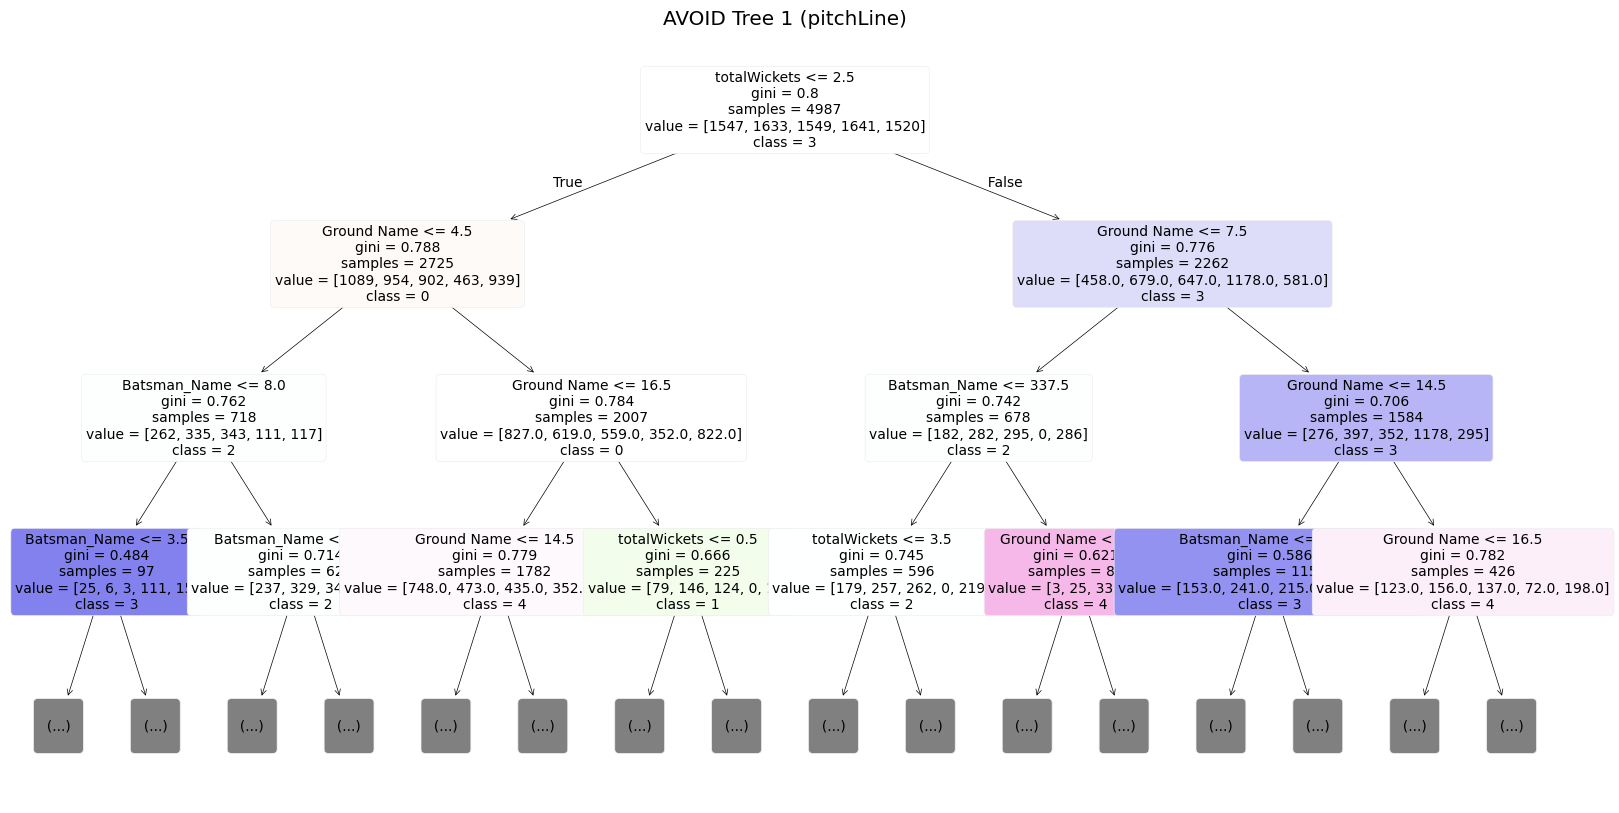

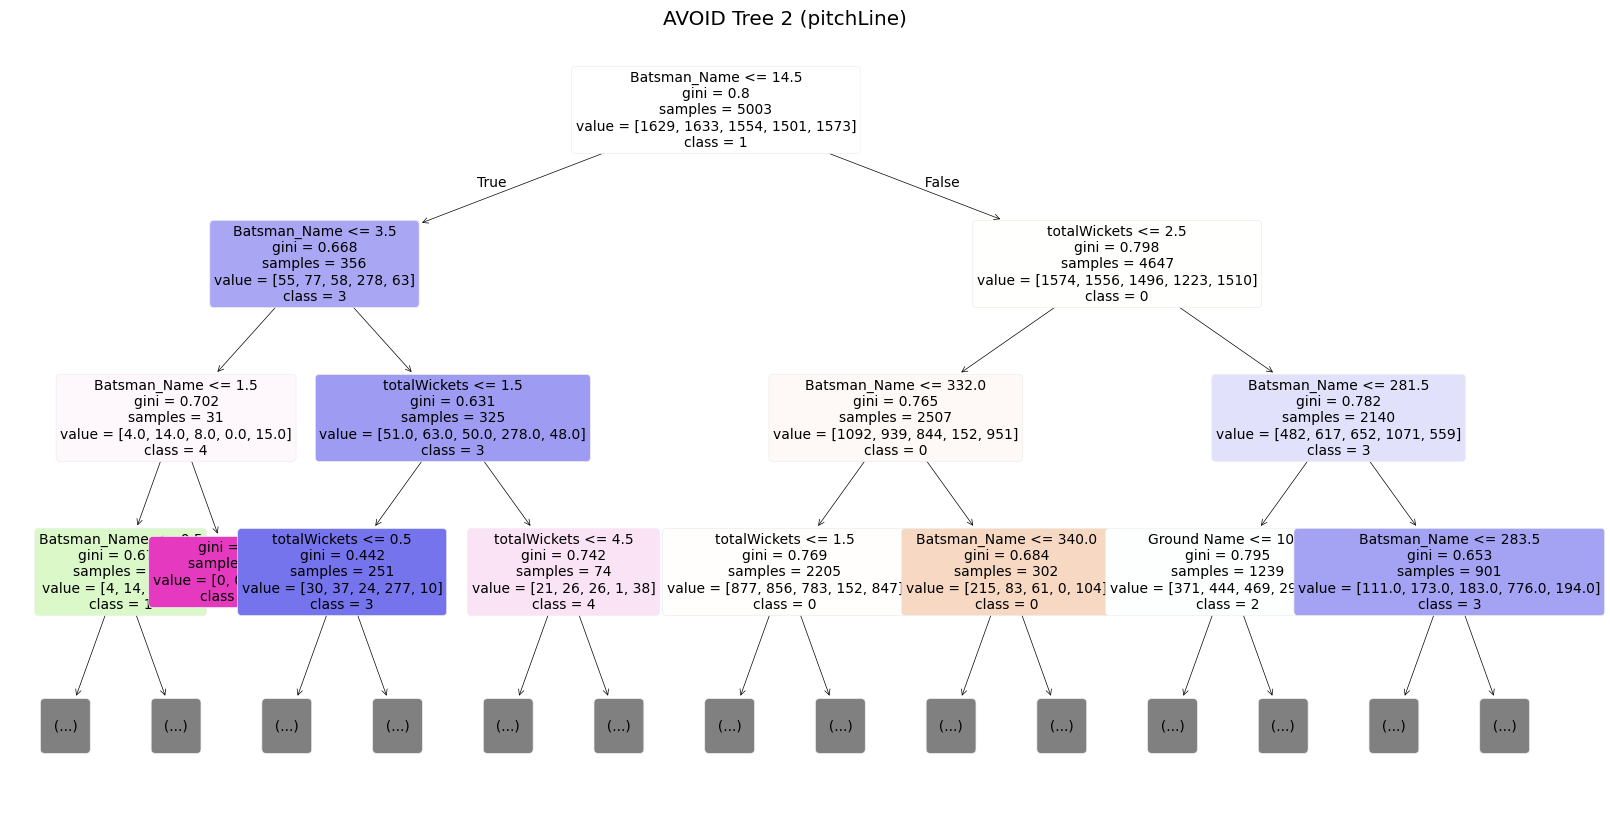

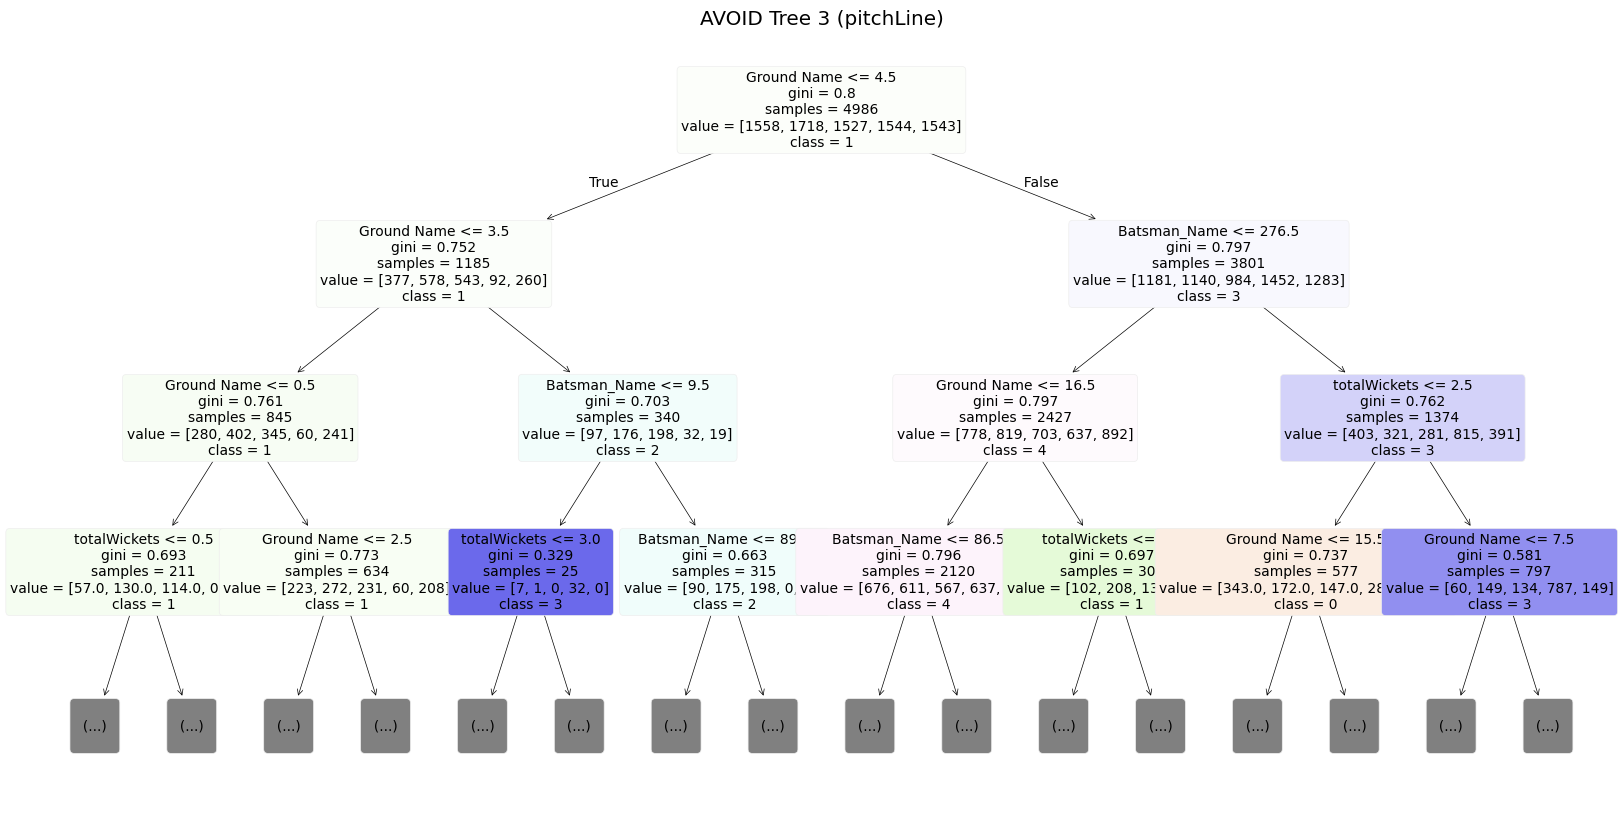


=== Avoidance Model for pitchLength ===
Selected features:  ['inningNumber', 'oversActual', 'totalRuns', 'time_of_day', 'Ground Name', 'Batsman_Name']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 91}

--- Train Performance ---
Accuracy: 0.9861647361647362
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       786
           1       0.97      0.97      0.97       197
           2       0.99      0.99      0.99      1094
           3       0.97      0.99      0.98       324
           4       0.99      0.99      0.99       682
           5       1.00      0.96      0.98        25

    accuracy                           0.99      3108
   macro avg       0.98      0.98      0.98      3108
weighted avg       0.99      0.99      0.99      3108


--- Test Performance ---
Accuracy: 0.2827763496143959
     

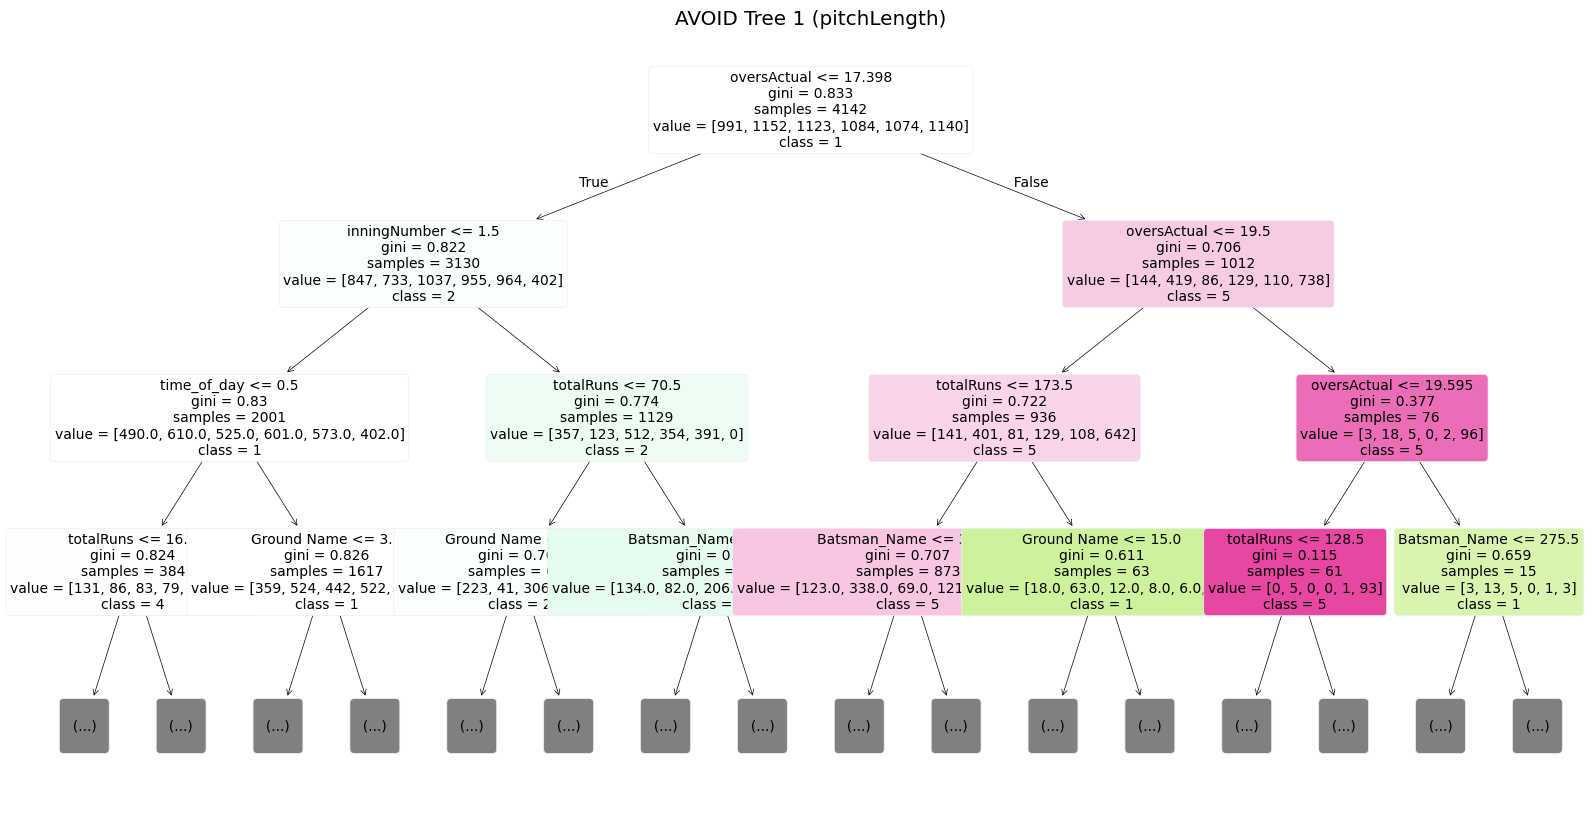

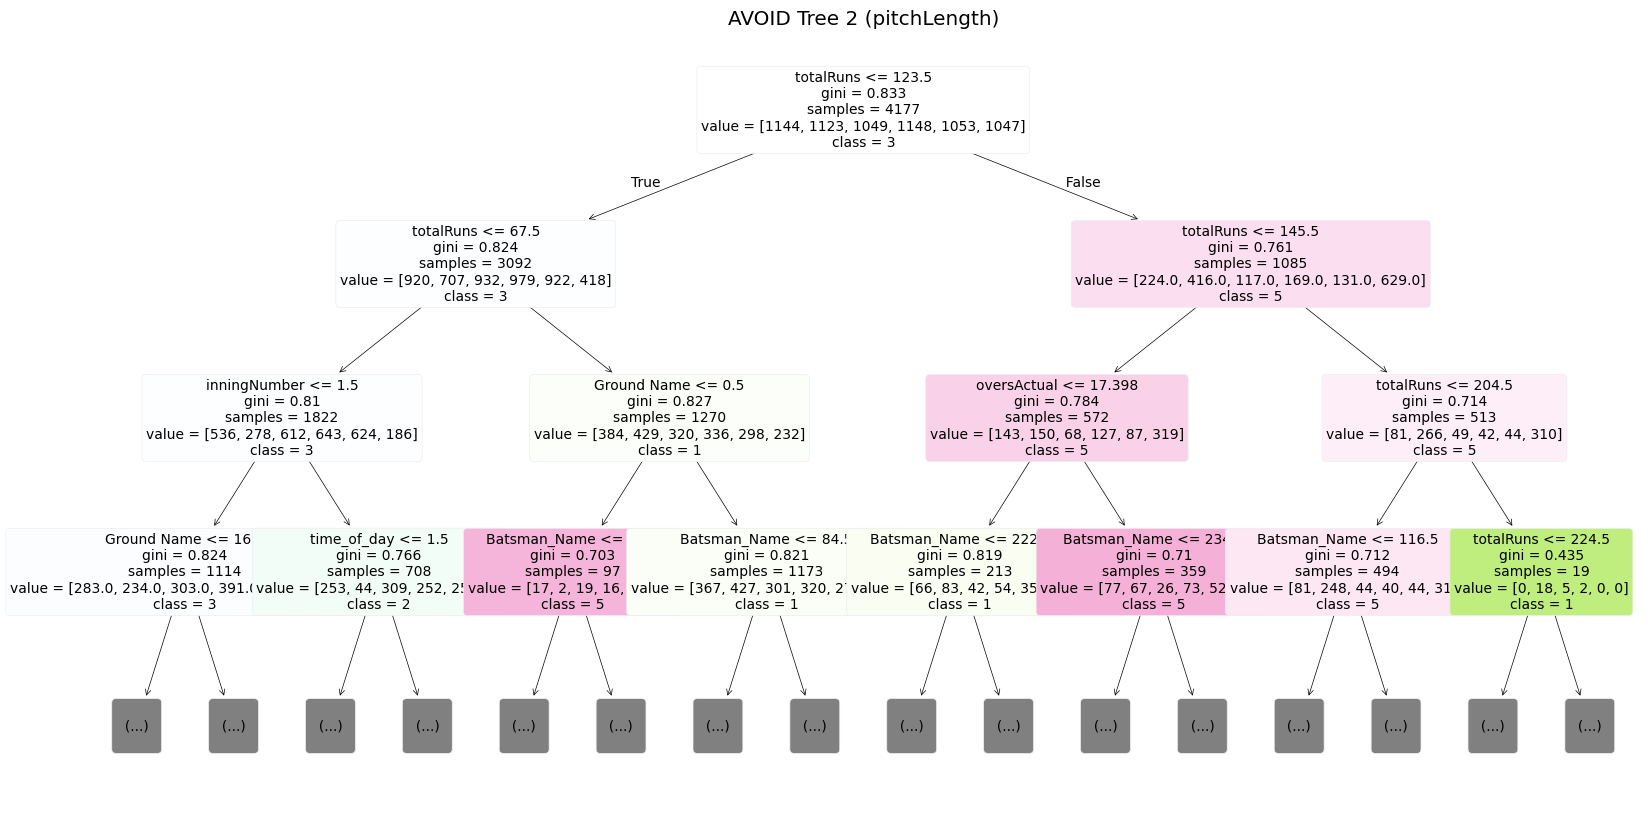

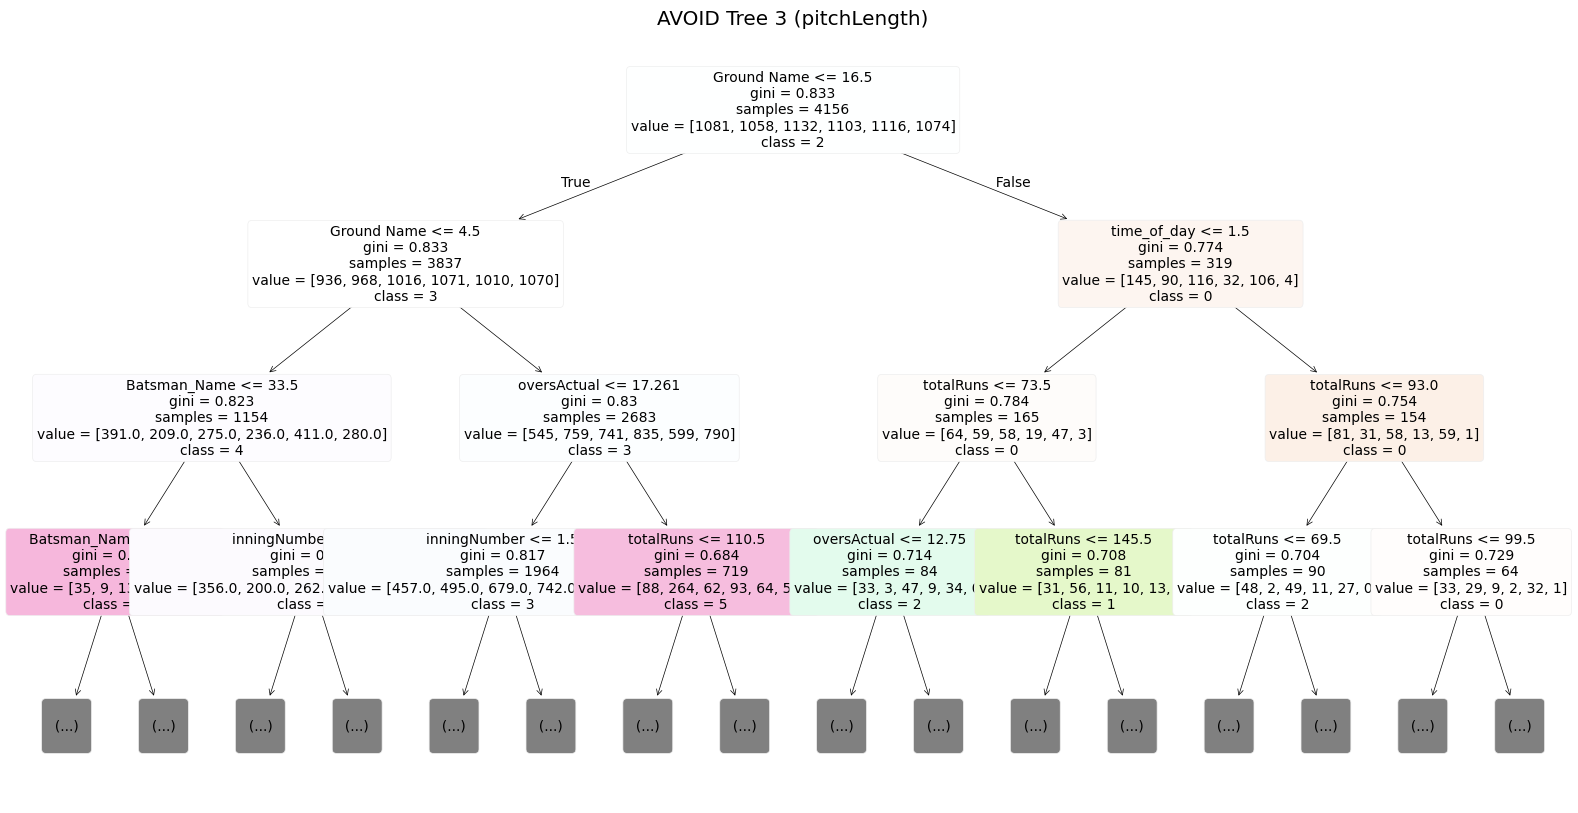


=== Avoidance Model for Bowler_Bowling_Style ===
Selected features:  ['oversActual', 'totalRuns', 'totalWickets', 'time_of_day', 'Ground Name', 'Batsman_Name', 'Batsman_Playing_Role']
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 91}

--- Train Performance ---
Accuracy: 0.9929214929214929
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       133
           1       0.99      0.99      0.99       251
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00         3
           4       0.99      1.00      1.00       125
           5       1.00      1.00      1.00        14
           6       0.99      0.99      0.99       183
           7       0.99      1.00      0.99        98
           8       1.00      1.00      1.00       517
           9       1.00      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


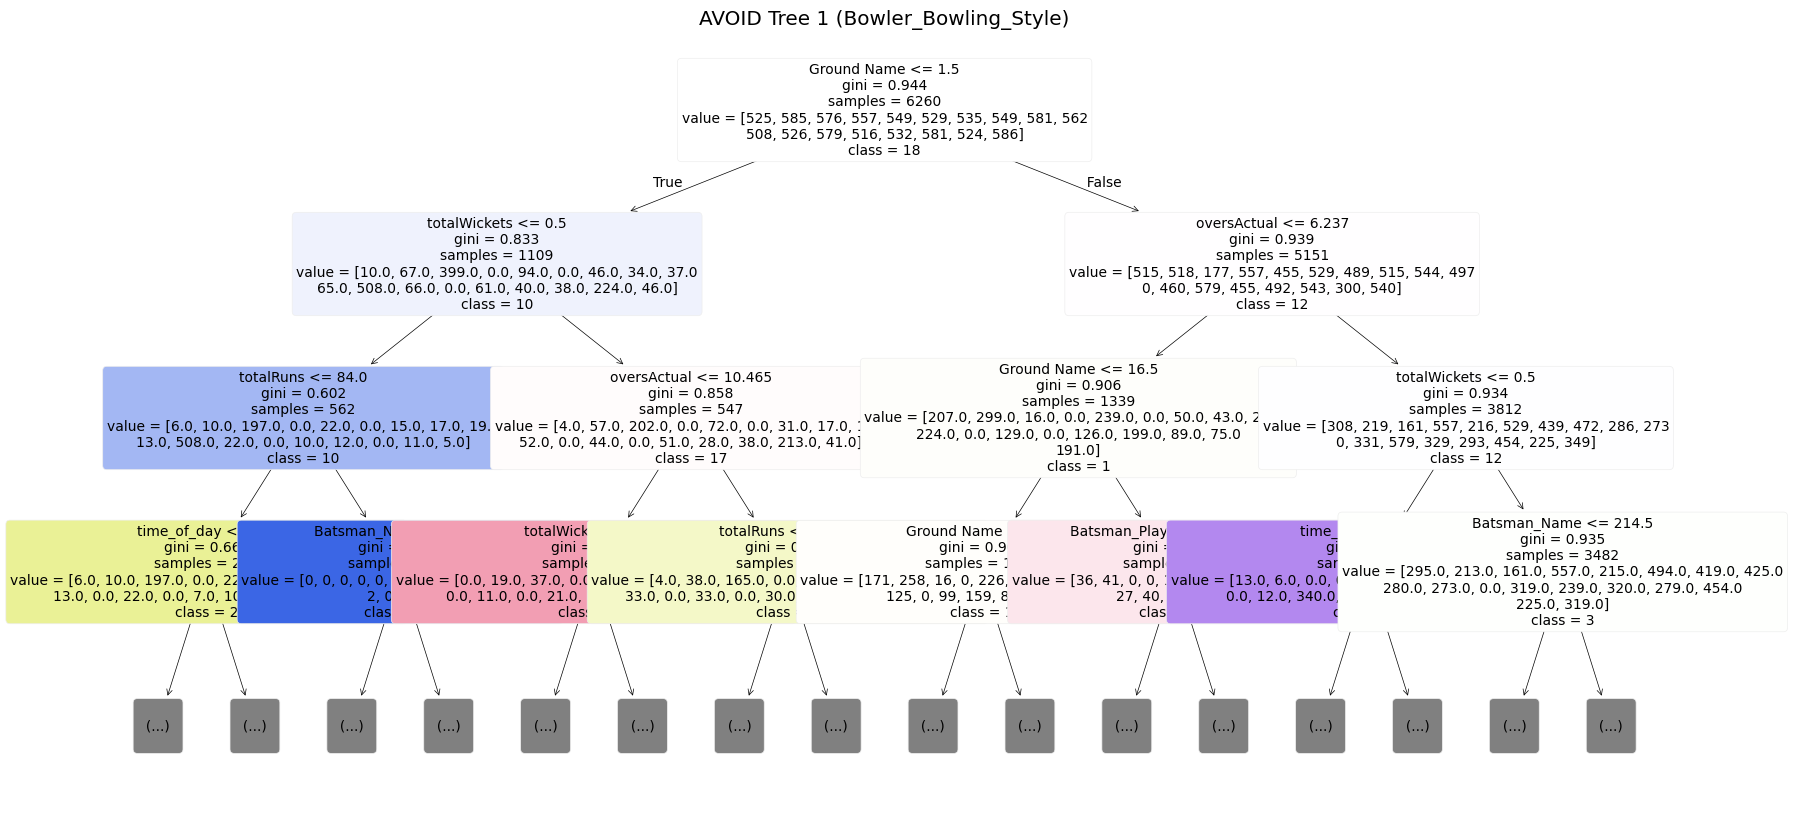

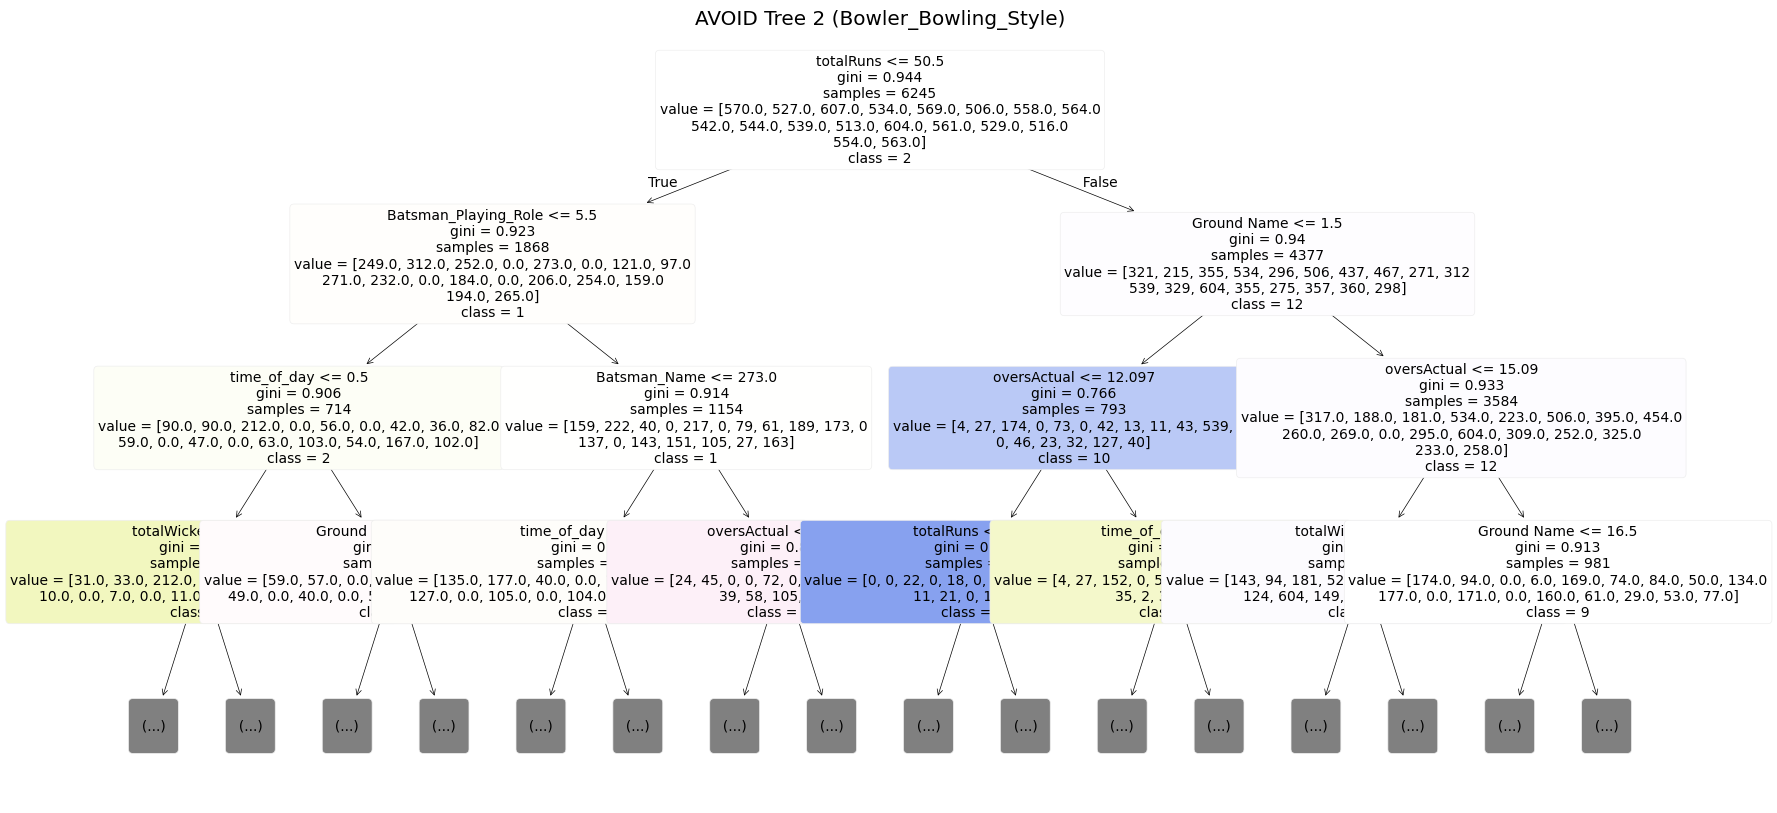

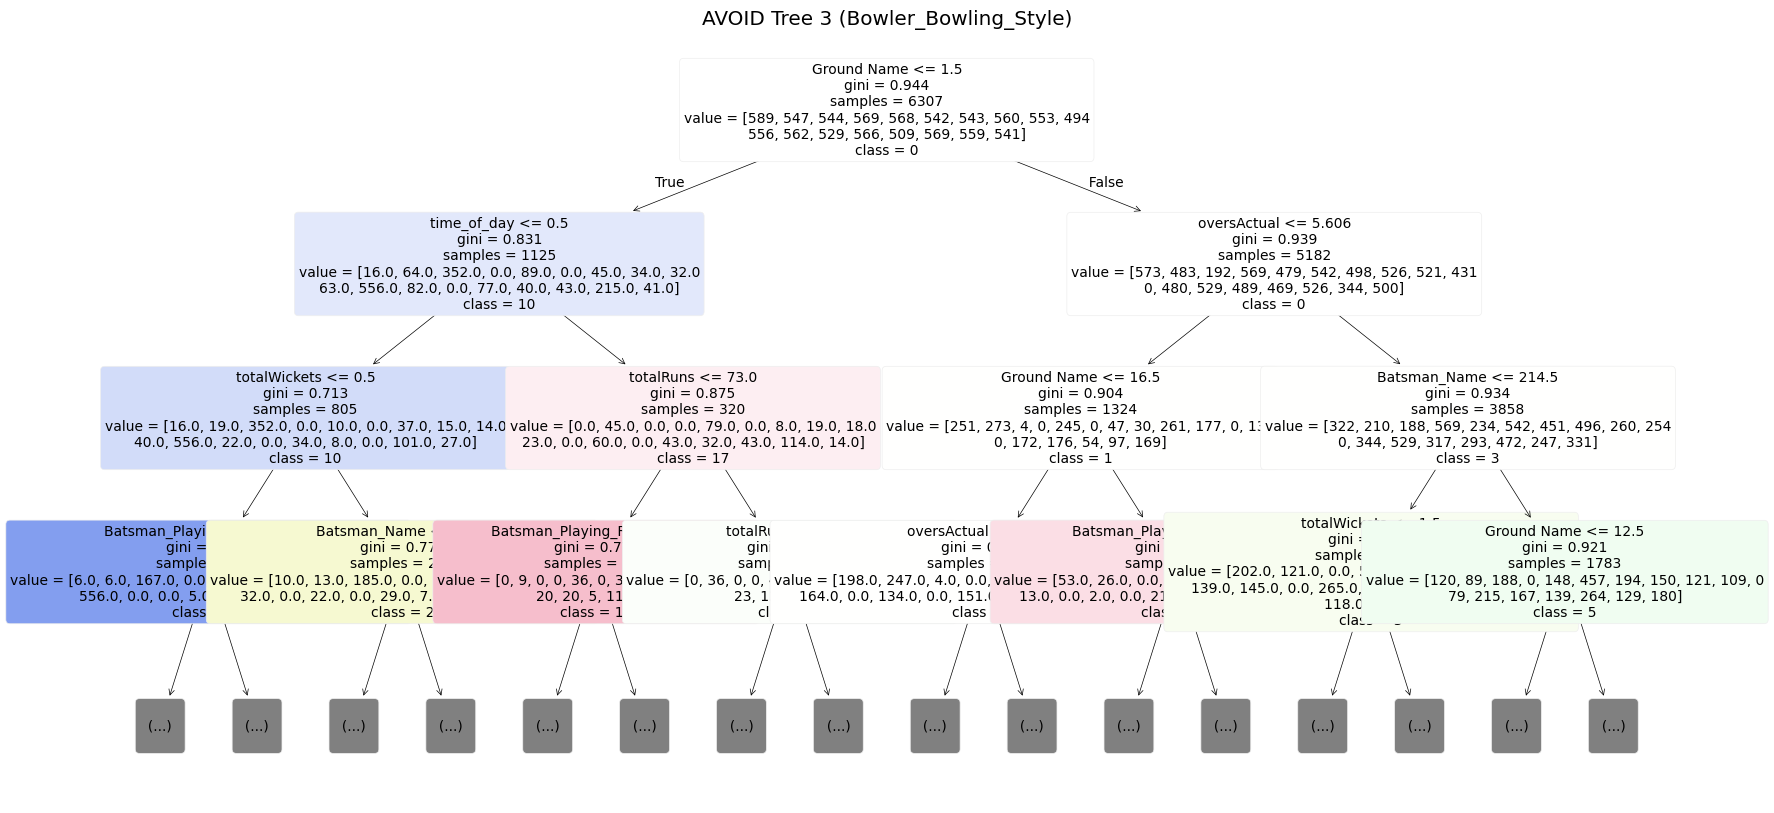

In [27]:
df_copy['avoid_target'] = ((df_copy['isWicket'] == 0) & (df_copy['run'] > threshold)).astype(int)

avoid_models = {}

param_dist = {
    'n_estimators': randint(50, 101),
    'max_depth': [10, 20, None],
    'min_samples_split': randint(2, 6),
    'min_samples_leaf': randint(1, 3),
    'max_features': ['sqrt']
}

for target_col in target_outputs:
    print(f"\n=== Avoidance Model for {target_col} ===")

    df_bad = df_copy[df_copy['avoid_target'] == 1]
    X_avoid = df_bad[input_cols]
    y_avoid = df_bad[target_col]

    class_counts = y_avoid.value_counts()
    valid_classes = class_counts[class_counts >= 2].index
    mask = y_avoid.isin(valid_classes)

    X_avoid = X_avoid[mask]
    y_avoid = y_avoid[mask]

    mi_scores = mutual_info_classif(X_avoid, y_avoid, discrete_features='auto')
    selected_features = [f for f, score in zip(input_cols, mi_scores) if score > 0.01]
    print("Selected features: ", selected_features)
    X_avoid = X_avoid[selected_features]

    X_temp, X_test, y_temp, y_test = train_test_split(X_avoid, y_avoid,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y_avoid)

    sm = SMOTE(random_state=42, k_neighbors=1)
    X_resampled, y_resampled = sm.fit_resample(X_temp, y_temp)

    cv_strategy = StratifiedKFold(n_splits=5)
    random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                       param_distributions=param_dist,
                                       n_iter=10,
                                       cv=cv_strategy,
                                       scoring='roc_auc_ovr',
                                       n_jobs=-1,
                                       verbose=2,
                                       random_state=42)
    random_search.fit(X_resampled, y_resampled)
    best_model = random_search.best_estimator_
    avoid_models[target_col] = best_model

    print("Best Parameters:", random_search.best_params_)

    y_train_pred = best_model.predict(X_temp)
    print("\n--- Train Performance ---")
    print("Accuracy:", accuracy_score(y_temp, y_train_pred))
    print(classification_report(y_temp, y_train_pred))

    y_test_pred = best_model.predict(X_test)
    print("\n--- Test Performance ---")
    print("Accuracy:", accuracy_score(y_test, y_test_pred))
    print(classification_report(y_test, y_test_pred))

    for i in range(min(3, len(best_model.estimators_))):
        plt.figure(figsize=(20, 10))
        plot_tree(best_model.estimators_[i],
                  max_depth=3,
                  feature_names=X_temp.columns,
                  class_names=[str(cls) for cls in best_model.classes_],
                  filled=True, rounded=True, fontsize=10)
        plt.title(f"AVOID Tree {i+1} ({target_col})")
        plt.show()

    joblib.dump(best_model, f'{target_col}_avoid_model.pkl')